In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Rutas completas
TRAIN_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\train"
TEST_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\test"
BASE_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\archive"

In [ ]:
# Definir las dimensiones de las imágenes (ajustado a 96x96, más cercano a 44x44)
IMG_HEIGHT = 96
IMG_WIDTH = 96
BATCH_SIZE = 32

In [ ]:
# Definir las clases (emociones en inglés)
CLASSES = ['surprise', 'happy', 'neutral', 'angry', 'fear', 'sad', 'disgust']

In [ ]:
# Crear generadores de datos con aumentación más intensa para clases minoritarias
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

Found 22968 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

Found 5741 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de prueba (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [ ]:
# Obtener el número de clases y el mapeo de clases
num_classes = len(CLASSES)
class_indices = train_generator.class_indices
print("Número de clases:", num_classes)
print("Clases:", class_indices)

Número de clases: 7
Clases: {'surprise': 0, 'happy': 1, 'neutral': 2, 'angry': 3, 'fear': 4, 'sad': 5, 'disgust': 6}


In [ ]:
# Calcular pesos de clase con Scikit-learn
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.2933160650937552, 1: 0.5684585684585685, 2: 0.826068191627104, 3: 1.0266404434114071, 4: 1.0009587727708533, 5: 0.8491570541259982, 6: 9.401555464592715}


In [ ]:
# Construir el modelo MobileNetV2 con Transfer Learning
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Cargar MobileNetV2 preentrenado (sin la capa final)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Descongelar las últimas 20 capas para fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Añadir capas personalizadas más complejas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Capa adicional con más neuronas
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Capa adicional
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compilar el modelo con una tasa de aprendizaje baja para fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
# Entrenar el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(os.path.join(BASE_PATH, 'best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30
718/718 [==============================] - 254s 344ms/step - loss: 2.0141 - accuracy: 0.1935 - val_loss: 1.8652 - val_accuracy: 0.2310
Epoch 2/30
718/718 [==============================] - 260s 362ms/step - loss: 1.8499 - accuracy: 0.2358 - val_loss: 1.7610 - val_accuracy: 0.2999
Epoch 3/30
718/718 [==============================] - 233s 325ms/step - loss: 1.8021 - accuracy: 0.2627 - val_loss: 1.7336 - val_accuracy: 0.3080
Epoch 4/30
718/718 [==============================] - 229s 319ms/step - loss: 1.7611 - accuracy: 0.2893 - val_loss: 1.6998 - val_accuracy: 0.3431
Epoch 5/30
718/718 [==============================] - 206s 286ms/step - loss: 1.7402 - accuracy: 0.3093 - val_loss: 1.7500 - val_accuracy: 0.3144
Epoch 6/30
718/718 [==============================] - 252s 351ms/step - loss: 1.6955 - accuracy: 0.3313 - val_loss: 1.6535 - val_accuracy: 0.3569
Epoch 7/30
718/718 [==============================] - 230s 321ms/step - loss: 1.6725 - accuracy: 0.3327 - val_loss: 1.5828 -

In [ ]:
# Cargar el mejor modelo guardado
model.load_weights(os.path.join(BASE_PATH, 'best_model.h5'))

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

225/225 [==============================] - 22s 99ms/step - loss: 1.4371 - accuracy: 0.4540
Test Loss: 1.4371
Test Accuracy: 0.4540


In [ ]:
# Obtener predicciones y etiquetas reales
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

225/225 [==============================] - 24s 98ms/step


In [ ]:
# Calcular métricas con Scikit-learn
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

Classification Report:
              precision    recall  f1-score   support

    surprise       0.50      0.75      0.60       831
       happy       0.61      0.67      0.64      1774
     neutral       0.36      0.64      0.46      1233
       angry       0.31      0.32      0.32       958
        fear       0.37      0.05      0.08      1024
         sad       0.44      0.22      0.30      1247
     disgust       0.29      0.13      0.17       111

    accuracy                           0.45      7178
   macro avg       0.41      0.40      0.37      7178
weighted avg       0.45      0.45      0.42      7178



In [ ]:
# Calcular F1-score promedio
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

Weighted F1-Score: 0.4164


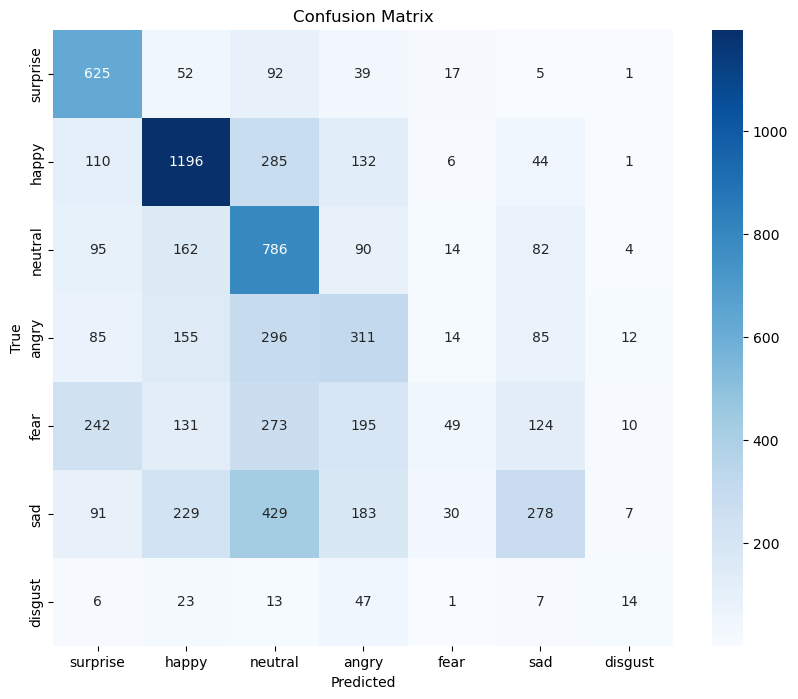

In [ ]:
# Crear y mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()